In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

# Load Dataset

In [2]:
# read `email_table.csv`
email_table = pd.read_csv('./data/email/email_table.csv')
email_table.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [3]:
# basic information
email_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [4]:
# check missing values
email_table.isnull().sum()

email_id               0
email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
dtype: int64

In [5]:
# read email_opened_table.csv
email_opened = pd.read_csv('./data/email/email_opened_table.csv')
email_opened.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [6]:
# basic information
email_opened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
email_id    10345 non-null int64
dtypes: int64(1)
memory usage: 80.9 KB


In [7]:
# read link_clicked_table.csv
link_table = pd.read_csv('./data/email/link_clicked_table.csv')
link_table.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [8]:
# basic information
link_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
email_id    2119 non-null int64
dtypes: int64(1)
memory usage: 16.6 KB


In [9]:
# check uniqueness of email_id in three tables
print('email_table.csv:\t', len(email_table['email_id'].unique()))
print('email_opened_table.csv:\t', len(email_opened['email_id'].unique()))
print('link_clicked_table.csv:\t', len(link_table['email_id'].unique()))

email_table.csv:	 100000
email_opened_table.csv:	 10345
link_clicked_table.csv:	 2119


# Data Processing

In [10]:
# create new columns `opened` and `clicked`
email_opened['opened'] = 1
link_table['clicked'] = 1
data = pd.merge(left=email_table, right=email_opened, how='left', on='email_id')
data = pd.merge(left=data, right=link_table, how='left', on='email_id')
data = data.fillna(value=0)
data['opened'] = data['opened'].astype(int)
data['clicked'] = data['clicked'].astype(int)
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


# Question 1

In [11]:
print('{0:25s} {1:>8.4f}%'.format('Opened user percentage:', data['opened'].mean() * 100))
print('{0:25s} {1:>8.4f}%'.format('Clicked user percentage:', data['clicked'].mean() * 100))

Opened user percentage:    10.3450%
Clicked user percentage:    2.1190%


# Question 2

In [12]:
data.groupby('clicked')['email_id'].count() / len(data)

clicked
0    0.97881
1    0.02119
Name: email_id, dtype: float64

Clearly, the data is highly imbalanced:
* $2.12\%$ of all the email is clicked. 
* $97.88\%$ of all the email is not clicked. 

The imbalance of the data is a major challange for similar problems.

### Visualization of `email_text`

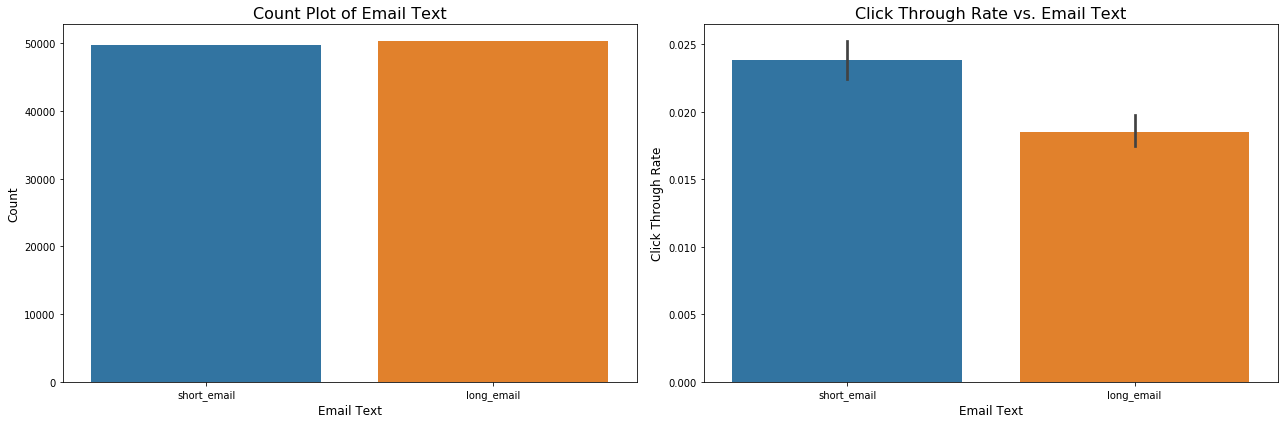

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_text', data=data, ax=ax[0])
ax[0].set_xlabel('Email Text', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Text', fontsize=16)

sns.barplot(x='email_text', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Text', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Text', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of `email_version`

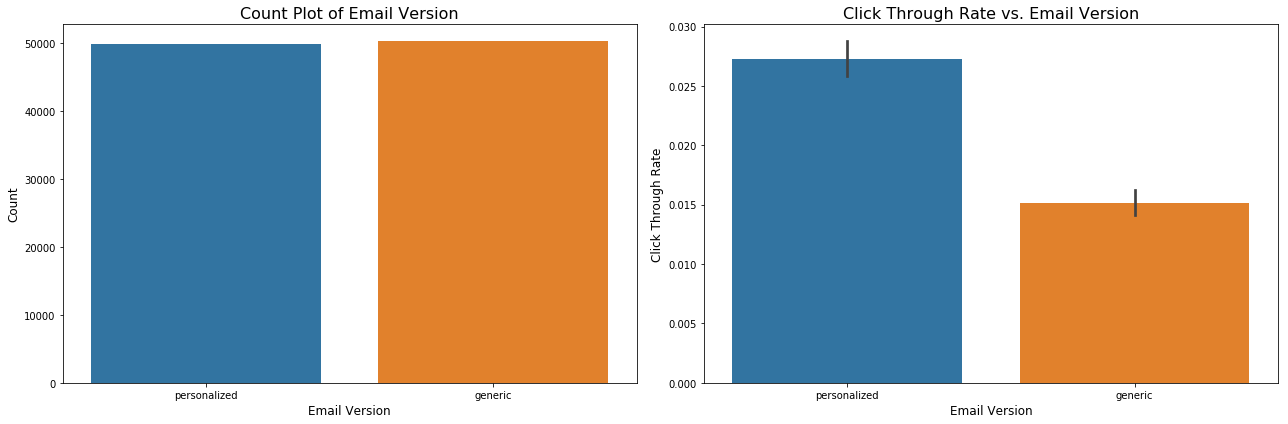

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_version', data=data, ax=ax[0])
ax[0].set_xlabel('Email Version', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Version', fontsize=16)

sns.barplot(x='email_version', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Version', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Version', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of `hour`

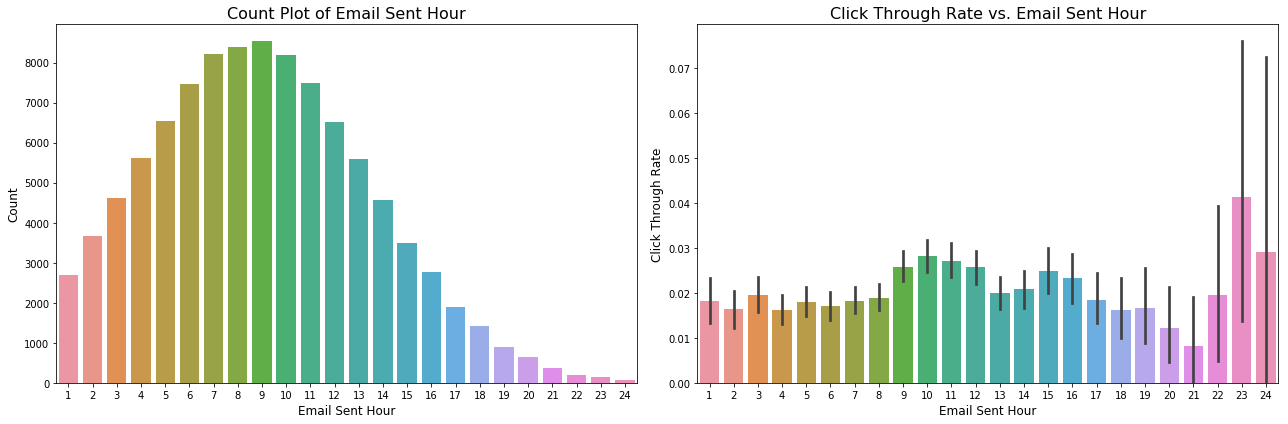

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='hour', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Hour', fontsize=16)

sns.barplot(x='hour', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Hour', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of `weekday`

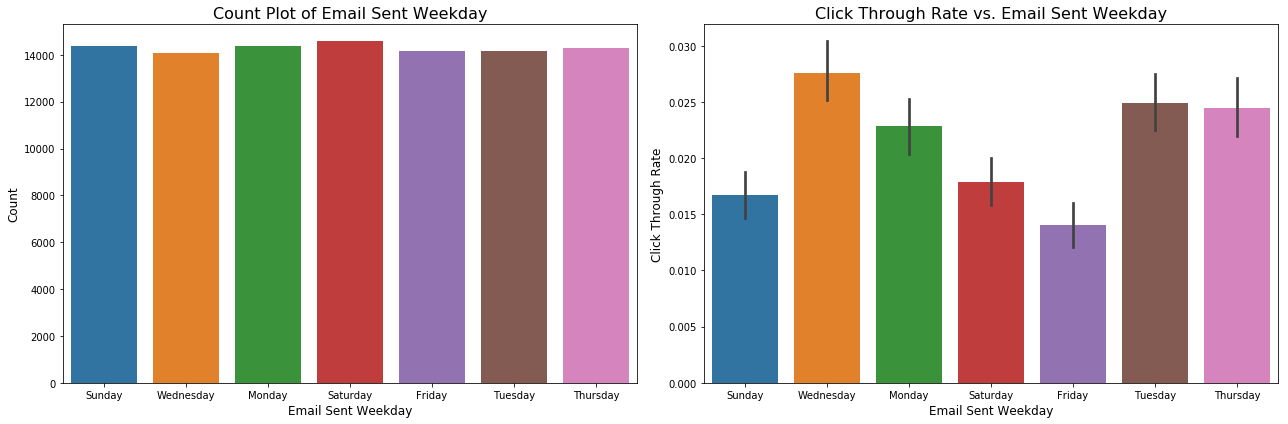

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='weekday', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Weekday', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Weekday', fontsize=16)

sns.barplot(x='weekday', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Weekday', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Weekday', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of `user_country`

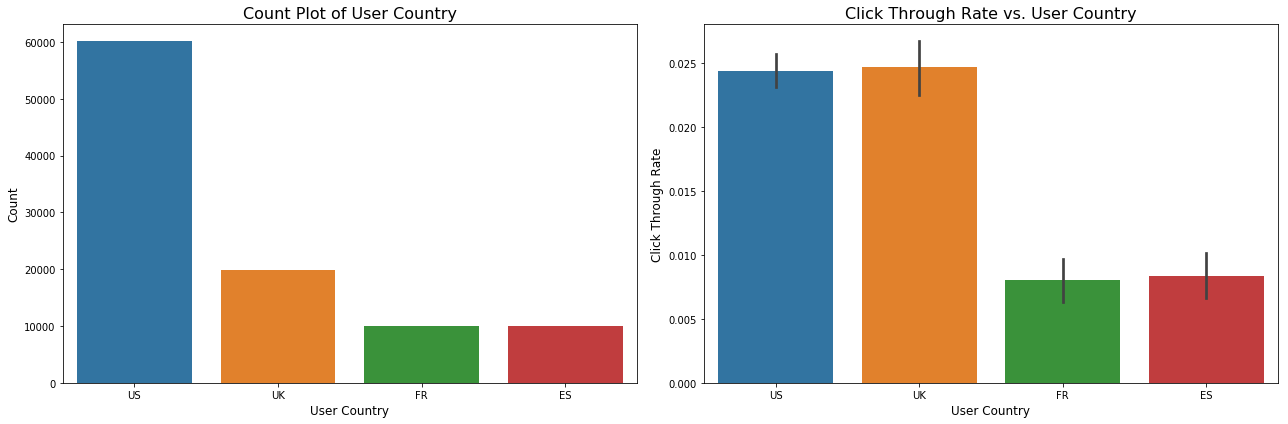

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_country', data=data, ax=ax[0])
ax[0].set_xlabel('User Country', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Country', fontsize=16)

sns.barplot(x='user_country', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Country', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Country', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of `user_past_purchases`

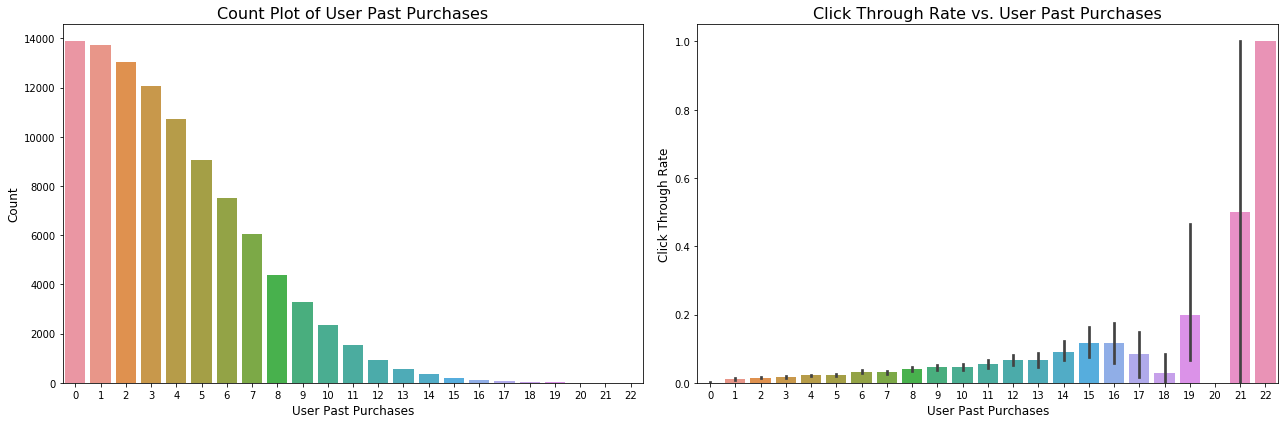

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_past_purchases', data=data, ax=ax[0])
ax[0].set_xlabel('User Past Purchases', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Past Purchases', fontsize=16)

sns.barplot(x='user_past_purchases', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Past Purchases', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Past Purchases', fontsize=16)
plt.tight_layout()
plt.show()

Clearly, different features have different influence on the user click-through-rate. Now, let's try to build some machine learning models to try to predict the click probability. In this notebook, I only implement the Random Forest model with the default parameter settings without advanced optimization, such as grid search and so on.

In [19]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-macosx) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-macosx) (build 25.121-b15, mixed mode)
  Starting server from /anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/fk/r5jtwkwx7rnc3ylykxjwpyq00000gp/T/tmpma5u5nb6
  JVM stdout: /var/folders/fk/r5jtwkwx7rnc3ylykxjwpyq00000gp/T/tmpma5u5nb6/h2o_jifuzhao_started_from_python.out
  JVM stderr: /var/folders/fk/r5jtwkwx7rnc3ylykxjwpyq00000gp/T/tmpma5u5nb6/h2o_jifuzhao_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.1
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_jifuzhao_2lksx7
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [20]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)
h2o_df['clicked'] = h2o_df['clicked'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
type,int,enum,enum,int,enum,enum,int,int,enum
mins,8.0,,,1.0,,,0.0,0.0,
mean,498690.1961600027,,,9.059300000000045,,,3.878450000000022,0.10345,
maxs,999998.0,,,24.0,,,22.0,1.0,
sigma,289230.7275342937,,,4.4396374417069655,,,3.1961097835771355,0.3045472459081676,
zeros,0,,,0,,,13877,89655,
missing,0,0,0,0,0,0,0,0,0
0,85120.0,short_email,personalized,2.0,Sunday,US,5.0,0.0,0
1,966622.0,long_email,personalized,12.0,Sunday,UK,2.0,1.0,1
2,777221.0,long_email,personalized,11.0,Wednesday,US,2.0,0.0,0


In [21]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['clicked'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
target = 'clicked'

In [22]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=10, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


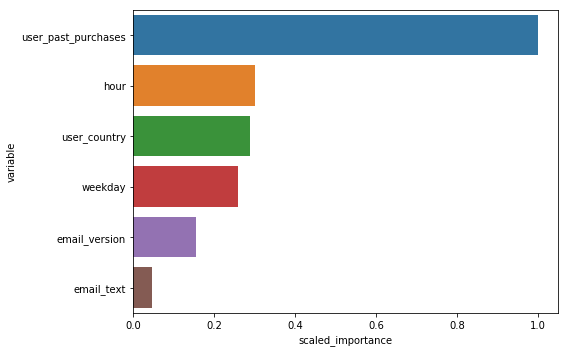

In [23]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.tight_layout()
plt.show()

In [24]:
# Make predictions
train_true = train.as_data_frame()['clicked'].values
test_true = test.as_data_frame()['clicked'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.98      1.00      0.99     24470
          1       0.00      0.00      0.00       530

avg / total       0.96      0.98      0.97     25000



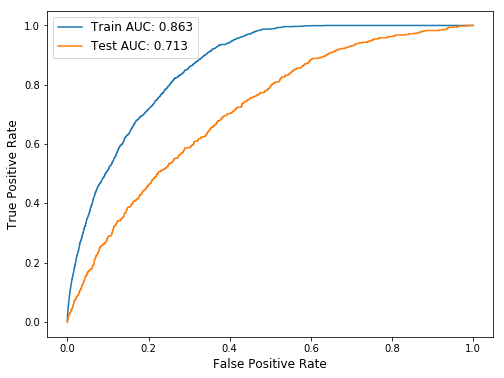

In [25]:
# ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


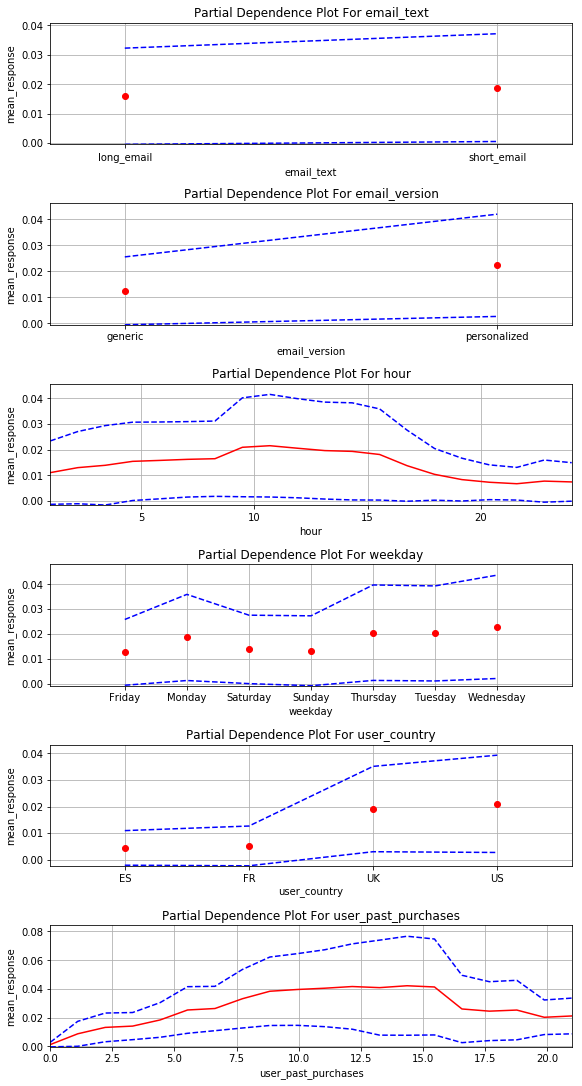

In [26]:
# Partial dependence plot
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))

In [27]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_8665 closed.


It seems that currently there are some overfitting, which could be solved with grid search.

# Question 3

Based on the model built previously, the company can send email to selected users that are predicted to have higher probability to click the link. 

To test it, we can conduct A/B test to see if the built model can actually help improve the click-through-rate.
* Randomly assign users to two groups, Control group and Experiment group.
* In Control group, still use the old email-campaign strategy, i.e., just send emails to all users in Control group.
* In Experiment group, use my model to predict whether the user will click the link or not. and only send emails to those users whose predictive result is positive.
* Preform a one-tail unpaired t-test to test whether Experiement group's population proportion is higher than Control group's population proportion.

# Question 4

See visualization and partial dependence plot for details, which should be very clear.